# Nomophobia Score Predictor

This notebook analyzes smartphone addiction (nomophobia) based on survey data and builds predictive models using various machine learning algorithms.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Load dataset
data = pd.read_csv('Nomophobia.csv')
print(f"Dataset shape: {data.shape}")
print(data.head())

Dataset shape: (603, 33)
             Timestamp                Email Address  Gender          Age  \
0   10/9/2023 23:25:15     pratapmohan579@gmail.com    Male  18-22 Years   
1  10/10/2023 21:55:37      saurabhch9369@gmail.com    Male  18-22 Years   
2  10/12/2023 11:58:14         sa20010917@gmail.com  Female  18-22 Years   
3  10/12/2023 12:02:58           sg260342@gmail.com  Female  18-22 Years   
4  10/12/2023 12:04:00  kartiklohanibly@outlook.com    Male  18-22 Years   

  Do you own a Smartphone? How many smartphones do you have?  \
0                      Yes                                 1   
1                      Yes                                 1   
2                      Yes                                 1   
3                      Yes                                 1   
4                      Yes                                 1   

  How many students have using Smartphone started before Covid or after Covid?  \
0                                       Before Covi

In [20]:
# Define unified scoring system
SCORING_SYSTEM = {
    'Age': {
        '15-17 Years': 5,
        '18-22 Years': 4,
        '23-25 Years': 3,
        '25 and Above': 1
    },
    'Gender': {
        'Male': 3,
        'Female': 3
    },
    'Time': {
        '0-2 hours': 1,
        '3-4 hours': 2,
        '5-7 hours': 3,
        '8-10 hours': 4,
        '10-13 hours': 5,
        '14 and above': 6
    },
    'Symptoms': {
        'Fever': 3,
        'Headache': 3,
        'Eye Problem': 3,
        'Frustrated': 3,
        'Anxiety': 3,
        'Others': 3
    },
    'Response': {
        'Strongly Agree': 3,
        'Agree': 2,
        'Neutral': 1,
        'Disagree': 0,
        'Strongly Disagree': -1
    }
}

def score_symptoms(symptoms_str, symptom_mapping):
    if pd.isna(symptoms_str):
        return 0
    symptoms_list = str(symptoms_str).split(', ')
    return sum([symptom_mapping.get(s.strip(), 0) for s in symptoms_list])

print('Scoring system defined.')

Scoring system defined.


In [21]:
# Create feature-target dataframe for modeling
df = data.copy()

# Map Age and Gender
df['Age'] = df.get('Age', df.get('Age Range', None)).map(SCORING_SYSTEM['Age'])
df['Gender'] = df.get('Gender', None).map(SCORING_SYSTEM['Gender'])

# Map Time
time_col = [col for col in df.columns if 'time' in col.lower() and 'smartphone' in col.lower()]
if time_col:
    df['Time'] = df[time_col[0]].map(SCORING_SYSTEM['Time'])

# Score Symptoms
symptom_col = [col for col in df.columns if 'physical' in col.lower() and 'psychological' in col.lower()]
if symptom_col:
    df['Symptoms'] = df[symptom_col[0]].apply(
        lambda x: score_symptoms(x, SCORING_SYSTEM['Symptoms'])
    )

# Map response columns to scores
response_cols = [col for col in df.columns if any(
    keyword in col.lower() for keyword in 
    ['check', 'boring', 'fun', 'skip', 'forget', 'deprive', 'anxiety', 
     'fail', 'fear', 'trouble', 'waste', 'mobile calculator', 'selfies']
)]

for col in response_cols:
    if col in df.columns:
        df[col] = df[col].map(SCORING_SYSTEM['Response'])

# Fill missing values
df = df.fillna(0)

# Calculate Nomophobia Score
feature_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] 
                and col not in ['Nomophobia_Score']]
df['Nomophobia_Score'] = df[feature_cols].sum(axis=1)

print('Feature engineering completed.')
print(f'Total features: {len(feature_cols)}')
print(f'Score range: {df["Nomophobia_Score"].min():.0f} - {df["Nomophobia_Score"].max():.0f}')

Feature engineering completed.
Total features: 17
Score range: 5 - 55


In [22]:
# Prepare data for modeling
X = df[feature_cols]
y = df['Nomophobia_Score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 482
Test set size: 121


In [23]:
# Train multiple models and compare
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'SVM (RBF)': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
}

results = {}

for name, model in models.items():
    if name == 'SVM (RBF)':
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'mse': mse,
        'r2': r2,
        'accuracy': r2 * 100
    }
    
    print(f'\n{name}')
    print(f'  MSE: {mse:.4f}')
    print(f'  R²: {r2:.4f}')
    print(f'  Accuracy: {r2*100:.2f}%')


Random Forest
  MSE: 2.4838
  R²: 0.9686
  Accuracy: 96.86%

Linear Regression
  MSE: 0.0000
  R²: 1.0000
  Accuracy: 100.00%

Decision Tree
  MSE: 7.5868
  R²: 0.9042
  Accuracy: 90.42%

SVM (RBF)
  MSE: 2.3926
  R²: 0.9698
  Accuracy: 96.98%


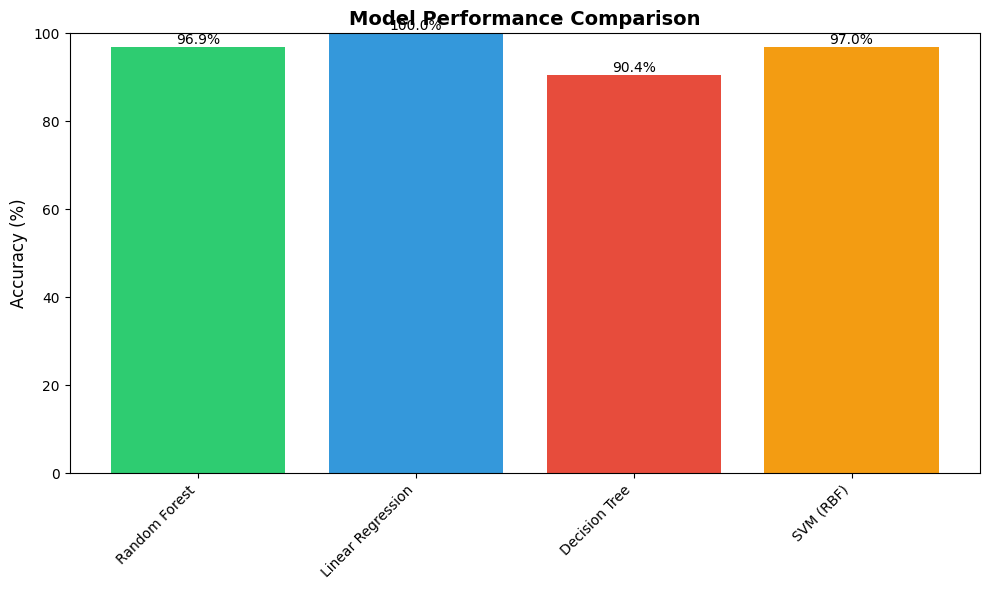

In [24]:
# Model comparison visualization
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

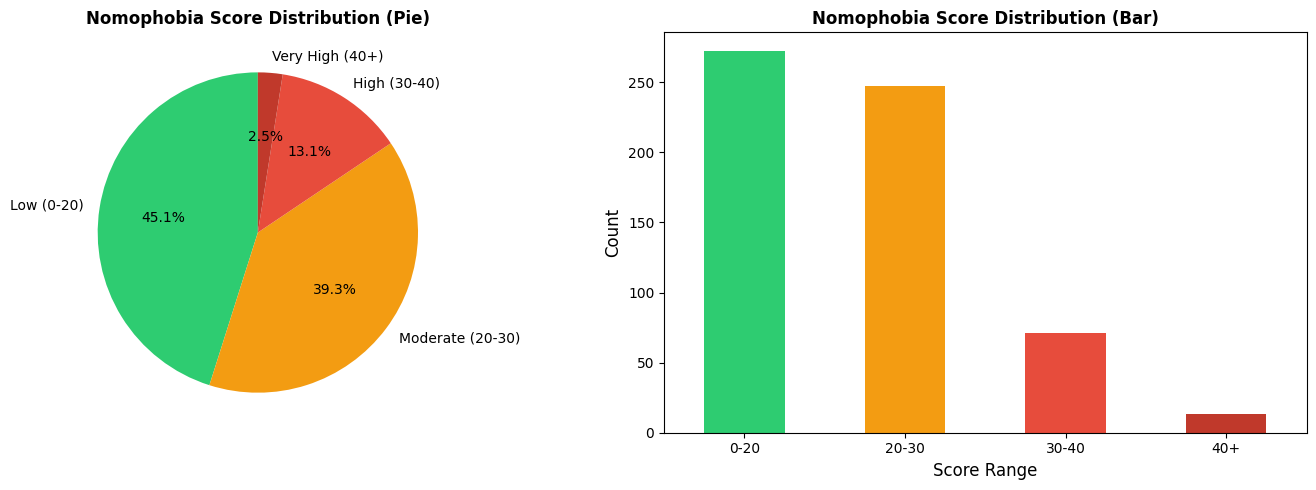


Score Statistics:
  Mean: 21.92
  Median: 21.00
  Std Dev: 7.98


In [25]:
# Distribution analysis of Nomophobia Scores
score_ranges = {
    'Low (0-20)': (df['Nomophobia_Score'] <= 20).sum(),
    'Moderate (20-30)': ((df['Nomophobia_Score'] > 20) & (df['Nomophobia_Score'] < 30)).sum(),
    'High (30-40)': ((df['Nomophobia_Score'] >= 30) & (df['Nomophobia_Score'] < 40)).sum(),
    'Very High (40+)': (df['Nomophobia_Score'] >= 40).sum()
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71', '#f39c12', '#e74c3c', '#c0392b']
ax1.pie(score_ranges.values(), labels=score_ranges.keys(), autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax1.set_title('Nomophobia Score Distribution (Pie)', fontweight='bold')

ranges = pd.cut(df['Nomophobia_Score'], bins=[0, 20, 30, 40, 100], 
                labels=['0-20', '20-30', '30-40', '40+'])
ranges.value_counts().sort_index().plot(kind='bar', ax=ax2, color=colors)
ax2.set_xlabel('Score Range', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Nomophobia Score Distribution (Bar)', fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print(f'\nScore Statistics:')
print(f'  Mean: {df["Nomophobia_Score"].mean():.2f}')
print(f'  Median: {df["Nomophobia_Score"].median():.2f}')
print(f'  Std Dev: {df["Nomophobia_Score"].std():.2f}')

In [26]:
# Prediction function using best model
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

def predict_nomophobia_score(age, gender, time_usage, symptoms=None, **responses):
    input_dict = {
        'Age': SCORING_SYSTEM['Age'].get(age, 0),
        'Gender': SCORING_SYSTEM['Gender'].get(gender, 0),
        'Time': SCORING_SYSTEM['Time'].get(time_usage, 0),
        'Symptoms': score_symptoms(symptoms, SCORING_SYSTEM['Symptoms']) if symptoms else 0,
    }
    
    for key, value in responses.items():
        input_dict[key] = SCORING_SYSTEM['Response'].get(value, 0)
    
    input_df = pd.DataFrame([input_dict])
    input_df = input_df.reindex(columns=feature_cols, fill_value=0)
    
    score = best_model.predict(input_df)[0]
    
    if score <= 20:
        severity = 'Low'
    elif score < 30:
        severity = 'Moderate'
    elif score < 40:
        severity = 'High'
    else:
        severity = 'Very High'
    
    return {'score': score, 'severity': severity}

# Example prediction
example = predict_nomophobia_score(
    age='18-22 Years',
    gender='Male',
    time_usage='3-4 hours',
    symptoms='Headache',
    check_social_media='Agree',
    boring_studies='Strongly Agree',
    no_fun='Agree'
)

print(f'\nExample Prediction:')
print(f'  Score: {example["score"]:.2f}')
print(f'  Severity: {example["severity"]}')
print(f'\nBest Model: {best_model_name}')


Example Prediction:
  Score: 12.00
  Severity: Low

Best Model: Linear Regression


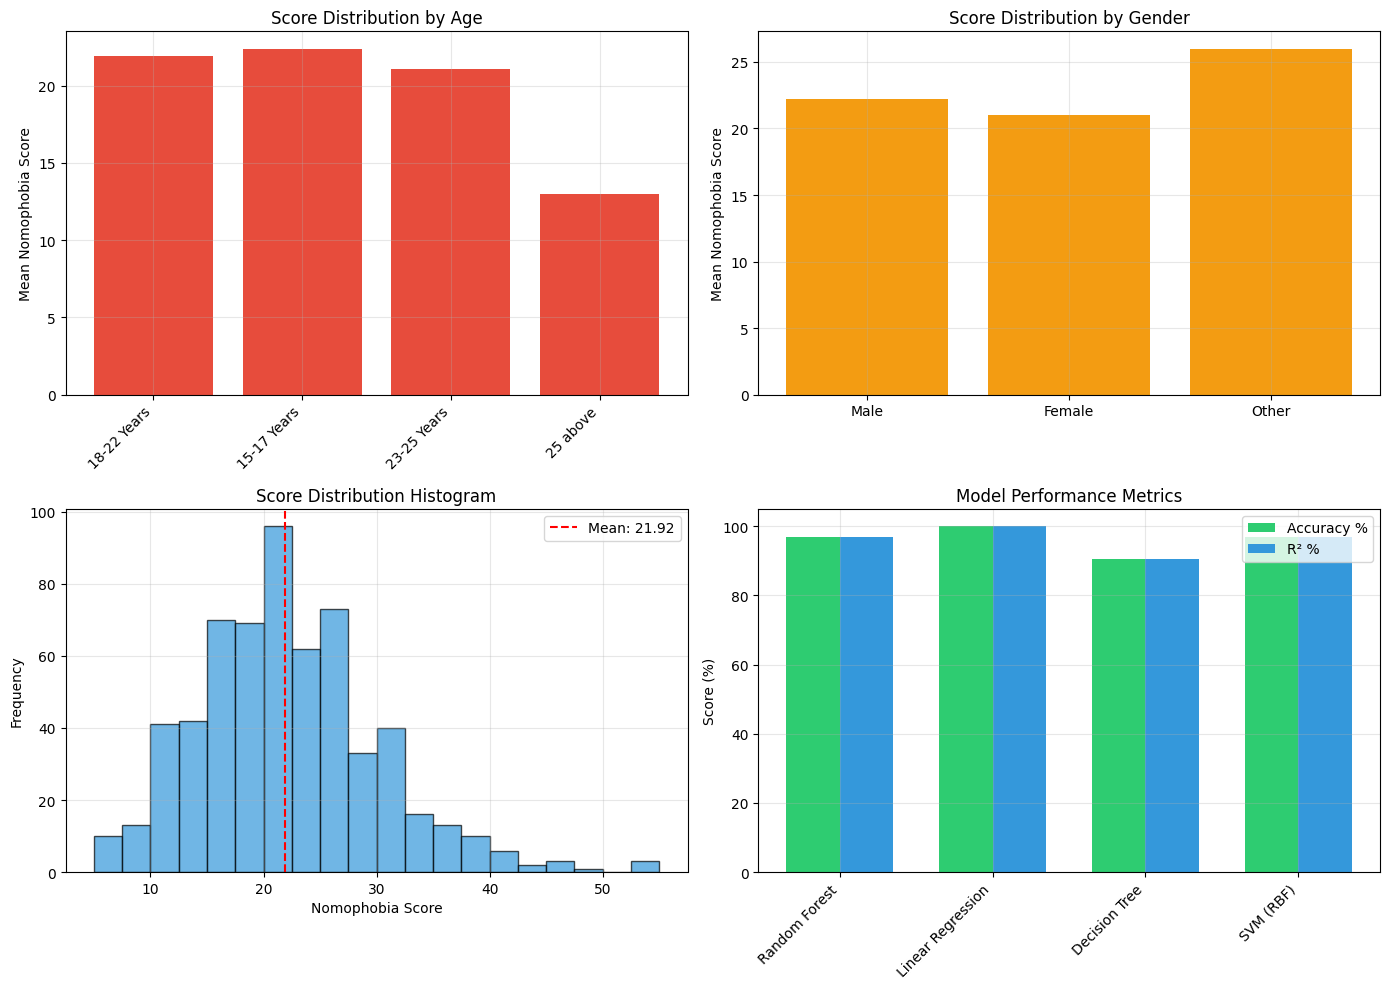

In [27]:
# Visualization: Score Distribution by Demographics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# By Age
age_col = [col for col in data.columns if 'age' in col.lower()]
if age_col:
    age_data = data[age_col[0]].dropna().unique()[:5]
    age_scores_list = []
    for age in age_data:
        scores = df[data[age_col[0]] == age]['Nomophobia_Score'].values
        if len(scores) > 0:
            age_scores_list.append({'Age': age, 'Mean Score': scores.mean(), 'Count': len(scores)})
    if age_scores_list:
        age_df = pd.DataFrame(age_scores_list)
        axes[0, 0].bar(range(len(age_df)), age_df['Mean Score'], color='#e74c3c')
        axes[0, 0].set_xticks(range(len(age_df)))
        axes[0, 0].set_xticklabels(age_df['Age'], rotation=45, ha='right')
        axes[0, 0].set_ylabel('Mean Nomophobia Score')
        axes[0, 0].set_title('Score Distribution by Age')
        axes[0, 0].grid(alpha=0.3)

# By Gender
gender_col = [col for col in data.columns if 'gender' in col.lower()]
if gender_col:
    gender_data = data[gender_col[0]].dropna().unique()
    gender_scores_list = []
    for gender in gender_data:
        scores = df[data[gender_col[0]] == gender]['Nomophobia_Score'].values
        if len(scores) > 0:
            gender_scores_list.append({'Gender': gender, 'Mean Score': scores.mean()})
    if gender_scores_list:
        gender_df = pd.DataFrame(gender_scores_list)
        axes[0, 1].bar(gender_df['Gender'], gender_df['Mean Score'], color='#f39c12')
        axes[0, 1].set_ylabel('Mean Nomophobia Score')
        axes[0, 1].set_title('Score Distribution by Gender')
        axes[0, 1].grid(alpha=0.3)

# Score histogram
axes[1, 0].hist(df['Nomophobia_Score'], bins=20, color='#3498db', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Nomophobia Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Score Distribution Histogram')
axes[1, 0].axvline(df['Nomophobia_Score'].mean(), color='r', linestyle='--', label=f"Mean: {df['Nomophobia_Score'].mean():.2f}")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Model metrics comparison
model_names_list = list(results.keys())
metrics_data = {
    'Accuracy': [results[m]['accuracy'] for m in model_names_list],
    'R² Score': [results[m]['r2']*100 for m in model_names_list]
}
x = np.arange(len(model_names_list))
width = 0.35
axes[1, 1].bar(x - width/2, metrics_data['Accuracy'], width, label='Accuracy %', color='#2ecc71')
axes[1, 1].bar(x + width/2, metrics_data['R² Score'], width, label='R² %', color='#3498db')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(model_names_list, rotation=45, ha='right')
axes[1, 1].set_ylabel('Score (%)')
axes[1, 1].set_title('Model Performance Metrics')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

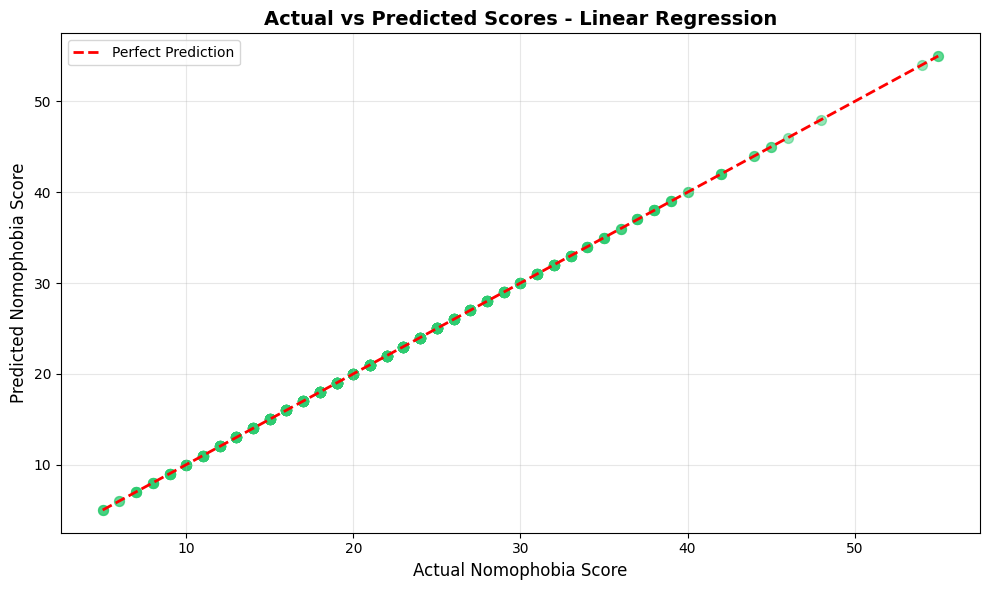

In [28]:
# Visualization: Actual vs Predicted Scores
# Get predictions on full dataset to show variance
X_full = df[feature_cols]
if best_model_name == 'SVM (RBF)':
    scaler = StandardScaler()
    X_full_scaled = scaler.fit_transform(X_full)
    y_full_pred = best_model.predict(X_full_scaled)
else:
    y_full_pred = best_model.predict(X_full)

plt.figure(figsize=(10, 6))
plt.scatter(df['Nomophobia_Score'], y_full_pred, alpha=0.5, s=50, color='#2ecc71')
plt.plot([df['Nomophobia_Score'].min(), df['Nomophobia_Score'].max()],
         [df['Nomophobia_Score'].min(), df['Nomophobia_Score'].max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Nomophobia Score', fontsize=12)
plt.ylabel('Predicted Nomophobia Score', fontsize=12)
plt.title(f'Actual vs Predicted Scores - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Visualization: Feature Importance (for Tree-based models)
if best_model_name in ['Random Forest', 'Decision Tree']:
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], color='#3498db')
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title(f'Top 15 Features - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature importance not available for {best_model_name}")

Feature importance not available for Linear Regression


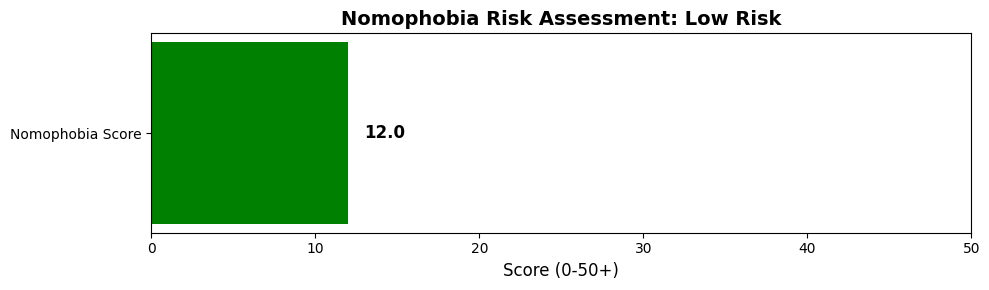

In [30]:
# Visualization: Individual Prediction Score Gauge
def plot_nomophobia_score_gauge(score):
    """Create a visual gauge for nomophobia severity."""
    if score <= 20:
        color = 'green'
        severity = 'Low Risk'
    elif score < 30:
        color = 'blue'
        severity = 'Moderate Risk'
    elif score < 40:
        color = 'orange'
        severity = 'High Risk'
    else:
        color = 'red'
        severity = 'Very High Risk'
    
    plt.figure(figsize=(10, 3))
    plt.barh(['Nomophobia Score'], [score], color=color, height=0.5)
    plt.xlim(0, 50)
    plt.xlabel('Score (0-50+)', fontsize=12)
    plt.title(f'Nomophobia Risk Assessment: {severity}', fontsize=14, fontweight='bold')
    plt.text(score + 1, 0, f'{score:.1f}', va='center', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot for example prediction
plot_nomophobia_score_gauge(example['score'])